In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import tifffile as tiff 
import pickle
from pathlib import Path
from skimage import io

from datetime import datetime
from deepcell.applications import NuclearSegmentation
from deepcell.applications import CellTracking

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import re


In [2]:
# tif_path = Path(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\TIF')
# tif_files = list(tif_path.glob('*.tif'))
# well_dict = {}
# for tif_file in tif_files:
#     file_name = tif_file.stem.split('_')
#     well_name = file_name[2]
#     view_name = file_name[3]
    
#     if well_name not in well_dict:
#         well_dict[well_name] = {}
#     if view_name not in well_dict[well_name]:
#         well_dict[well_name][view_name] = []

#     well_dict[well_name][view_name].append(tif_file)

# for well, views in well_dict.items():
#     for view , view_tif in views.items():
#         print(f'well:{well} , view:{view}, {len(view_tif)}')

In [3]:
# tif_arr = well_dict['D2']['1']

#### Tasks
- Imaris vs DeepCell:
    - Cell detection
      - Counting Agreeable cells and disagreeable cells (thorugh IoU)
    - Cell Tracking
      - Track length comparision 
      - Track agreable

- Gathering data
  - Run DeepCell with mpp = 1.24 on 4 wells
    - Centroids , Morphologies, Embeddings, RAW TIF

#### Questions
- Lookup Tables 
  - Pixel intensity (255) background (100)
- Excel position values
  - The TIFF we got is 1408*1040
  - In the Imaris Excel there are position values of 1742 in the X and 1200 in the Y , why ?
    - pixel to micron with (mpp = 1.24)
  
- How should we compare the results ?
  - Our framework can track objects for more than 70 frames
  - Seems like the Imaris tracks for about 10 frames
    - ANSWER delta +3 micron - Correleation coeffifcient

$~$

- Let's define the setting
  - Classification
    - Per label
  - Clustering - Unsupervised
    - Per cell
      - Being able to show the cells that were clustered - understand why they were clustered differently
    - *Check Autoencoders
  - Per well  experimental metadata
    - Per cell - we have kinetic ,morphological and embeddings (TBD) points 
  - Target 
    - Undertstand the features that are relevant for classification
    - Analyze the physical features differences between different groups


$~$

- On all JH011
  - On Imaris
  - On DeepCell
    - Take every second frame

- Send to Amir basic trajectory like Imaris 
  - amirpollak@mail.tau.ac.il
- Until Monday
  - Clustering by trajectories

#### Session With Nimrod
- Make sure we approach time series
- Temporal CNN 

In [8]:
import pandas as pd
imaris_path =r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Excel\C-2_MK001_D2_P1.xls'
df_imaris = pd.read_excel(imaris_path,sheet_name="Center of Image Mass Ch=1")
df_imaris

,Center of Image Mass X,Center of Image Mass Y,Center of Image Mass Z,Unit,Category,Channel,Collection,Time,Parent,ID
0,1525.661011,622.234009,0.62,um,Surface,1,Center of Image Mass,1,1000000000,0
1,1525.155029,622.002014,0.62,um,Surface,1,Center of Image Mass,2,1000000000,1
2,1524.557983,622.075012,0.62,um,Surface,1,Center of Image Mass,4,1000000000,2
3,1524.531982,622.208984,0.62,um,Surface,1,Center of Image Mass,5,1000000000,3
4,219.518997,373.403015,0.62,um,Surface,1,Center of Image Mass,6,1000000001,4
...,...,...,...,...,...,...,...,...,...,...
26649,1717.326050,1036.589966,0.62,um,Surface,1,Center of Image Mass,94,1000003708,26037
26650,1717.743042,1037.093018,0.62,um,Surface,1,Center of Image Mass,95,1000003708,26638
26651,1736.338013,1075.430054,0.62,um,Surface,1,Center of Image Mass,93,1000003709,25438
26652,1738.343018,1069.744995,0.62,um,Surface,1,Center of Image Mass,94,1000003709,26054


In [9]:
cord_imaris = {}
for df in df_imaris.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['Center of Image Mass X'],row['Center of Image Mass Y']])
    cord_imaris[frame_time] = cord_list
# cord_imaris


In [10]:
deep_path = r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Results_D2_1_95_from_4\centroids.csv'
df_deep = pd.read_csv(deep_path)
df_deep

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
0,1,[ 511.6129 1219.7742],[ 511.77646 1228.0588 ],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,[ 516.81537 1363.9846 ],[ 521.9453 1364.9219],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[ 525.88153 1305.1138 ],[ 538.93243 1293.5 ],[ 535.02264 1303.8054 ],[ 542.2865 1292.1742],[ 541.10284 1294.08 ],[ 554.94965 1301.036 ],[ 556.087 1299.7609],[ 559.60486 1303.5646 ],[ 554.37683 1302.8116 ],[ 566.1348 1310.4045]
2,3,[540.5568 737.75 ],[539.79877 741.2195 ],NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[535.5851 642.9681],[540.72296 655.83105],[544.44684 654.7234 ],[544.4267 655.24 ],[532.0526 645.2368],[532.1622 645.6014],[536.0424 643.6606],[526.0922 630.1277],[521.1094 628.625 ],[524.3885 625.223 ]
3,4,[573.27155 637.24506],[576.66907 644.43164],NaN,NaN,NaN,[558.7842 660.3957],NaN,[537.88495 670.16815],[537.6585 669. ],...,[514.4091 626.8712],[505.0451 617.1429],[509.1898 615.5839],[510.33334 617.876 ],[508.98495 618.4436 ],[510.80148 620.0294 ],[511.14517 619.75806],[514.0992 622.0661],[507.6281 621.1157],[510.4762 616.94446]
4,5,[ 690.91345 1158.5529 ],[ 690.9945 1166.5275],NaN,NaN,NaN,[ 683.6713 1191.2963],NaN,NaN,NaN,...,[ 712.1929 1058.1 ],[ 716.4453 1058.4062],[ 722.6111 1056.6945],[ 717.0115 1045.6947],[ 718.25 1043.3724],[ 712.6272 1048.7041],[ 712.82825 1048.9509 ],[ 716.2952 1048.0476],[ 715.574 1051.4615],[ 716.0238 1046.5416]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,1110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 870.11835 1293.1959 ]
1110,1111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 965.0492 1390.041 ]
1111,1112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 980.614 1405.2632]
1112,1113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[993.64404 99.33898]


In [11]:
df_deep['0'].dropna().to_list()[0].split()

['[', '511.6129', '1219.7742]']

In [12]:
lambda x: (float(i) for i in re.findall("\d+\.\d+",x))

<function __main__.<lambda>(x)>

In [13]:
# df_d['2'][0]

In [14]:
df_d = df_deep.drop(columns = 'Unnamed: 0').fillna("A")
df_d = df_d.applymap(lambda x: [float(i) for i in re.findall("\d+\.\d+",x)])
df_d = df_d.applymap(lambda y: np.nan if len(y)<2 else y)
df_d

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,"[511.6129, 1219.7742]","[511.77646, 1228.0588]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[516.81537, 1363.9846]","[521.9453, 1364.9219]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[525.88153, 1305.1138]","[538.93243, 1293.5]","[535.02264, 1303.8054]","[542.2865, 1292.1742]","[541.10284, 1294.08]","[554.94965, 1301.036]","[556.087, 1299.7609]","[559.60486, 1303.5646]","[554.37683, 1302.8116]","[566.1348, 1310.4045]"
2,"[540.5568, 737.75]","[539.79877, 741.2195]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[535.5851, 642.9681]","[540.72296, 655.83105]","[544.44684, 654.7234]","[544.4267, 655.24]","[532.0526, 645.2368]","[532.1622, 645.6014]","[536.0424, 643.6606]","[526.0922, 630.1277]","[521.1094, 628.625]","[524.3885, 625.223]"
3,"[573.27155, 637.24506]","[576.66907, 644.43164]",NaN,NaN,NaN,"[558.7842, 660.3957]",NaN,"[537.88495, 670.16815]",NaN,"[535.81946, 678.2083]",...,"[514.4091, 626.8712]","[505.0451, 617.1429]","[509.1898, 615.5839]","[510.33334, 617.876]","[508.98495, 618.4436]","[510.80148, 620.0294]","[511.14517, 619.75806]","[514.0992, 622.0661]","[507.6281, 621.1157]","[510.4762, 616.94446]"
4,"[690.91345, 1158.5529]","[690.9945, 1166.5275]",NaN,NaN,NaN,"[683.6713, 1191.2963]",NaN,NaN,NaN,NaN,...,"[712.1929, 1058.1]","[716.4453, 1058.4062]","[722.6111, 1056.6945]","[717.0115, 1045.6947]","[718.25, 1043.3724]","[712.6272, 1048.7041]","[712.82825, 1048.9509]","[716.2952, 1048.0476]","[715.574, 1051.4615]","[716.0238, 1046.5416]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[870.11835, 1293.1959]"
1110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[965.0492, 1390.041]"
1111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[980.614, 1405.2632]"
1112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[993.64404, 99.33898]"


In [15]:
deep_cord = {}
for col in df_d.columns:
    frame_list = df_d[col].dropna().to_list()
    deep_cord[int(col)] = frame_list
# deep_cord

In [16]:
def per_frame_total_distance():
    dist_matrix = distance.cdist(A, B, 'euclidean')

amirpollak@mail.tau.ac.il

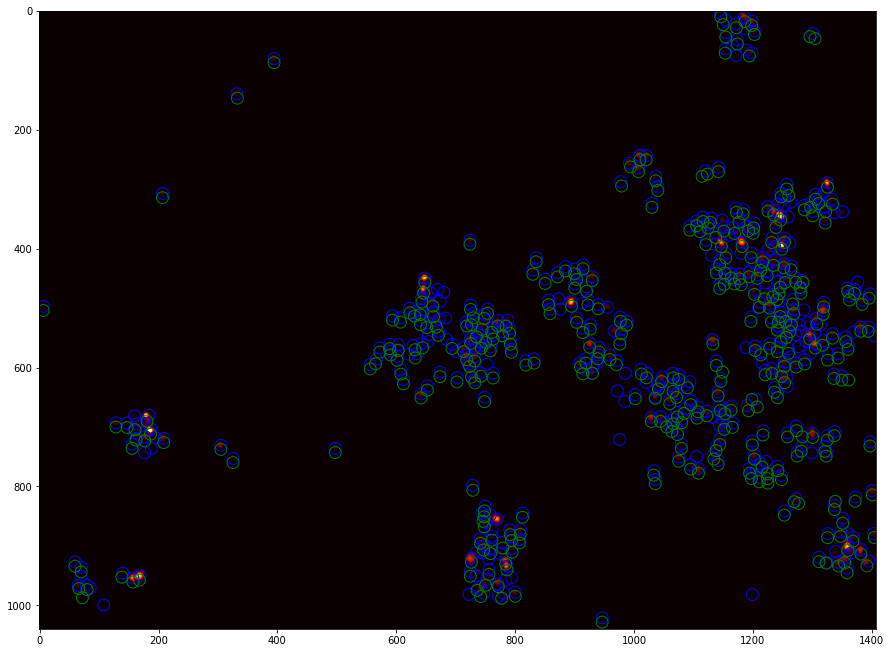

In [22]:
i = 60

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(plt.imread(tif_arr[i-1]), cmap = 'hot')

d_cord = deep_cord[i-4]
imaris_cord = cord_imaris[i]

for item in d_cord:
    ax.add_patch(plt.Circle((item[1],item[0]), 10, color='b',fill=False))
for item in imaris_cord:
    ax.add_patch(plt.Circle((item[0]/1.24,item[1]/1.24), 10, color='g',fill=False))


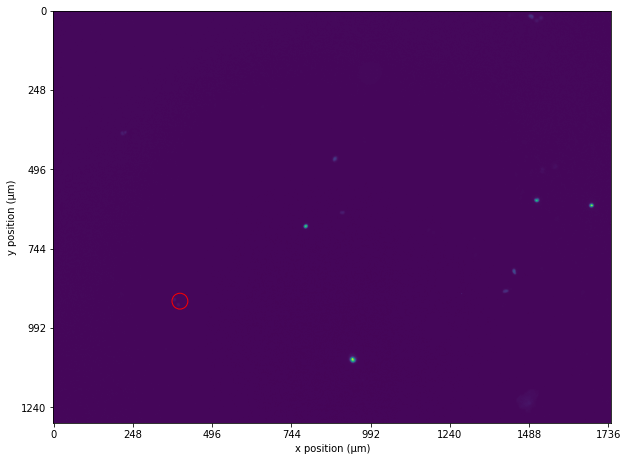

In [18]:
data = plt.imread(tif_arr[5])

pos = [395.1,908.38]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data)

formatter = lambda x, pos: f'{(x * 1.24):.0f}'
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('x position (μm)')
ax.set_ylabel('y position (μm)')

circle1 = plt.Circle((pos[0]/1.24, pos[1]/1.24), 20, color='r',fill=False)
ax.add_patch(circle1)

plt.show()

<AxesSubplot:>

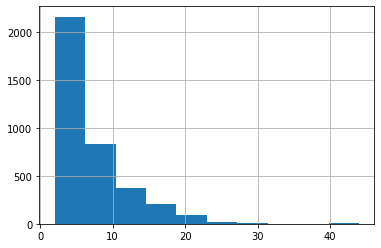

In [19]:
df_imaris.value_counts('Parent').hist()

In [20]:
df_imaris[df_imaris['Parent'] == 1000000003]

,Center of Image Mass X,Center of Image Mass Y,Center of Image Mass Z,Unit,Category,Channel,Collection,Time,Parent,ID
15,394.760010,908.189026,0.62,um,Surface,1,Center of Image Mass,6,1000000003,6
16,401.121002,905.005005,0.62,um,Surface,1,Center of Image Mass,7,1000000003,17
17,400.596008,903.445007,0.62,um,Surface,1,Center of Image Mass,8,1000000003,30
18,400.429993,921.361023,0.62,um,Surface,1,Center of Image Mass,10,1000000003,47
19,401.292999,927.791016,0.62,um,Surface,1,Center of Image Mass,11,1000000003,68
20,399.212006,931.593994,0.62,um,Surface,1,Center of Image Mass,12,1000000003,94
21,378.444000,902.328003,0.62,um,Surface,1,Center of Image Mass,15,1000000003,181
22,371.507996,900.697021,0.62,um,Surface,1,Center of Image Mass,16,1000000003,221
23,364.350006,902.546997,0.62,um,Surface,1,Center of Image Mass,17,1000000003,269
24,368.098999,899.382996,0.62,um,Surface,1,Center of Image Mass,18,1000000003,323


In [21]:
print(pos[0]/1.24, pos[1]/1.24)

318.6290322580645 732.5645161290323


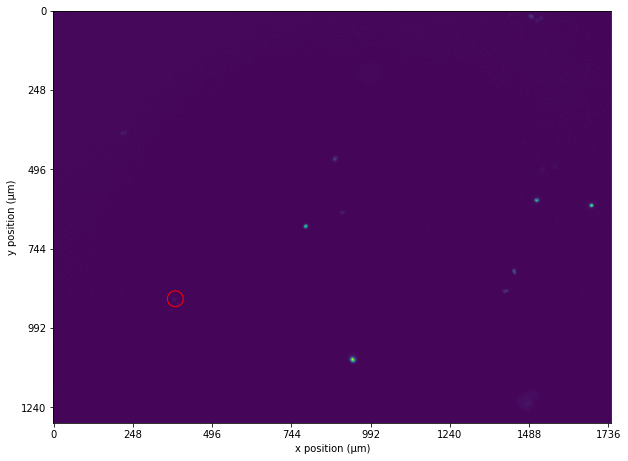

In [22]:
data = plt.imread(tif_arr[5])

pos = [395.1,908.38]
pos =deep_cord[3][-8]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data)

formatter = lambda x, pos: f'{(x * 1.24):.0f}'
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('x position (μm)')
ax.set_ylabel('y position (μm)')

circle1 = plt.Circle((pos[1], pos[0]), 20, color='r',fill=False)
ax.add_patch(circle1)

plt.show()

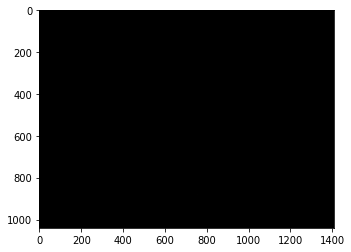

In [30]:
image = cv2.imread('C:\\Projects\\TAU\\DL-Workshop\\Images_Ilan\\JH0011\\TIF\\C-2_MK001_D2_1_2022y05m23d_17h00m.tif')


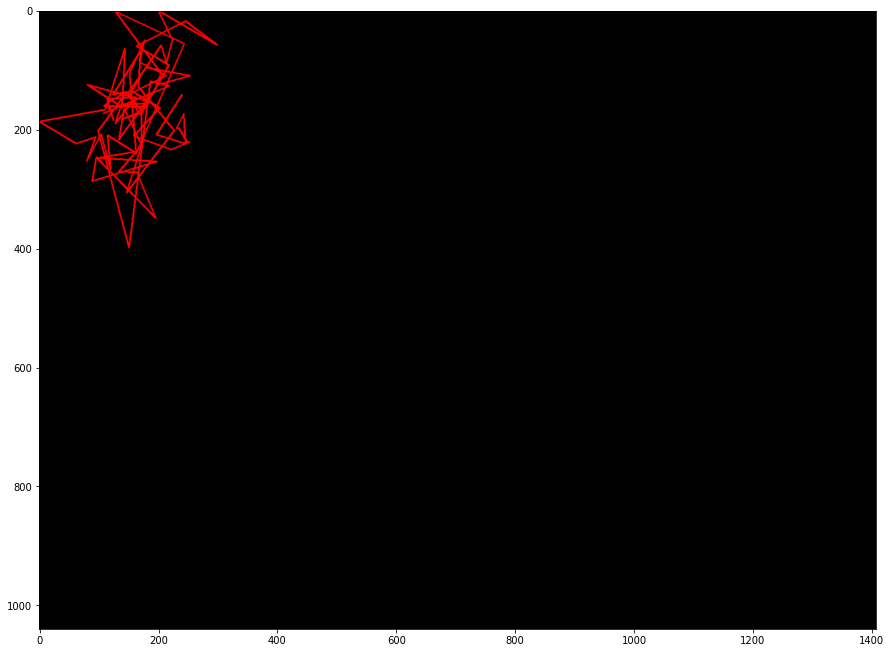

In [42]:
import cv2
import numpy as np
image = cv2.imread('C:\\Projects\\TAU\\DL-Workshop\\Images_Ilan\\JH0011\\TIF\\C-2_MK001_D2_1_2022y05m23d_17h00m.tif')

# List of points
points =list(df_d.loc[25,:].dropna())
# convert to numpy array and reshape
points = np.array(points)
points = [((points - points.min(axis = 0)) * 10)]
points = np.array(points)

points = points.reshape((-1, 1, 2))

# color, thickness and isClosed
color = (255, 0, 0)
thickness = 2
isClosed = False

# drawPolyline
image = cv2.polylines(image, np.int32([points]), isClosed, color, thickness)

fig, ax = plt.subplots(figsize=(15, 15))
# show image
ax.imshow(image, cmap= 'hot')


In [43]:
df_imaris[df_imaris['Parent'] == 1000000003]

,Center of Image Mass X,Center of Image Mass Y,Center of Image Mass Z,Unit,Category,Channel,Collection,Time,Parent,ID
15,394.760010,908.189026,0.62,um,Surface,1,Center of Image Mass,6,1000000003,6
16,401.121002,905.005005,0.62,um,Surface,1,Center of Image Mass,7,1000000003,17
17,400.596008,903.445007,0.62,um,Surface,1,Center of Image Mass,8,1000000003,30
18,400.429993,921.361023,0.62,um,Surface,1,Center of Image Mass,10,1000000003,47
19,401.292999,927.791016,0.62,um,Surface,1,Center of Image Mass,11,1000000003,68
20,399.212006,931.593994,0.62,um,Surface,1,Center of Image Mass,12,1000000003,94
21,378.444000,902.328003,0.62,um,Surface,1,Center of Image Mass,15,1000000003,181
22,371.507996,900.697021,0.62,um,Surface,1,Center of Image Mass,16,1000000003,221
23,364.350006,902.546997,0.62,um,Surface,1,Center of Image Mass,17,1000000003,269
24,368.098999,899.382996,0.62,um,Surface,1,Center of Image Mass,18,1000000003,323


In [45]:
df_imaris[df_imaris['Parent'] == 1000000003][['Center of Image Mass X','Center of Image Mass Y']].to_numpy()

array([[394.76000977, 908.18902588],
       [401.1210022 , 905.00500488],
       [400.5960083 , 903.44500732],
       [400.42999268, 921.36102295],
       [401.29299927, 927.79101562],
       [399.21200562, 931.59399414],
       [378.44400024, 902.32800293],
       [371.50799561, 900.69702148],
       [364.3500061 , 902.54699707],
       [368.09899902, 899.38299561],
       [368.62200928, 900.59698486]])

In [54]:
points = df_imaris[df_imaris['Parent'] == 1000000003][['Center of Image Mass X','Center of Image Mass Y']].to_numpy()
points = points/1.24

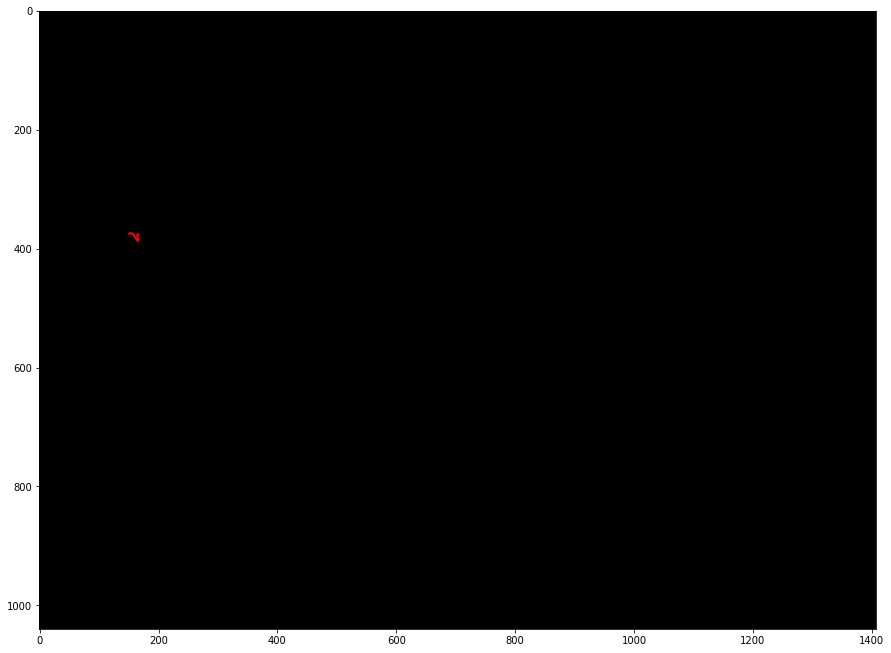

In [59]:
import cv2
import numpy as np
image = cv2.imread('C:\\Projects\\TAU\\DL-Workshop\\Images_Ilan\\JH0011\\TIF\\C-2_MK001_D2_1_2022y05m23d_17h00m.tif')

# List of points
points = df_imaris[df_imaris['Parent'] == 1000000003][['Center of Image Mass X','Center of Image Mass Y']].to_numpy()
points = points/2.4
# convert to numpy array and reshape


points = points.reshape((-1, 1, 2))

# color, thickness and isClosed
color = (255, 0, 0)
thickness = 2
isClosed = False

# drawPolyline
image = cv2.polylines(image, np.int32([points]), isClosed, color, thickness)

fig, ax = plt.subplots(figsize=(15, 15))
# show image
ax.imshow(image, cmap= 'hot')
